In [33]:
import numpy as np
import matplotlib.pylab as plt
from math import *
#from sklearn.models import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn import svm
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib notebook

In [34]:
import warnings

In [35]:
warnings.filterwarnings('ignore')

In [36]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [37]:
from sklearn.metrics import mean_squared_error as mse

In [38]:
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader

In [39]:
df = pd.read_csv('inputs/SVMD_1.csv')

In [40]:
df

,IMF-1,IMF-2,IMF-3,IMF-4
0,7.850187,-0.843075,-0.029416,0.683727
1,7.850133,-0.838198,-0.025512,0.638413
2,7.850024,-0.828471,-0.017903,0.550865
3,7.849860,-0.813951,-0.006975,0.427030
4,7.849637,-0.794723,0.006710,0.275308
...,...,...,...,...
1435,8.992862,-0.264966,0.921262,-0.225028
1436,8.991859,-0.270280,1.033266,-0.342685
1437,8.991105,-0.274290,1.119610,-0.438165
1438,8.990603,-0.276974,1.178303,-0.505399


In [41]:
from sklearn.preprocessing import MinMaxScaler

In [42]:
imfs = np.array([df[col].values for col in df.columns])

In [43]:
imfs[0].shape

(1440,)

In [44]:
from processing import create_features, split_data

In [46]:
from lssvm import LSSVMRegression as LSSVM

In [62]:
from ebqpso import EBQPSO

In [64]:
def adjust_params(params):
    gamma = np.power(10, params[0]).astype(float)
    sigma = np.power(10, params[1]).astype(float)
    m = int(params[2])
    return [gamma, sigma, m]

In [65]:
def get_test_error():
    series = pd.Series(imf1)
    df = create_features(series, param_imf1['m'])
    tr_arr, val_arr, tes_arr = split_data(df, int(.6*df.shape[0]))
    ytr = tr_arr['t']
    xtr = tr_arr.drop('t', axis=1)
    yte = tes_arr['t']
    xte = tes_arr.drop('t', axis=1)

    reg = LSSVM(kernel='rbf', gamma=param_imf1['gamma'], sigma=param_imf1['sigma'])
    reg.fit(xtr, ytr)
    yp = reg.predict(xte)
    mse(yte, yp)

In [66]:
global X

In [75]:
def f(p):
    gamma = np.power(10, p[0]).astype(float)
    sigma = np.power(10, p[1]).astype(float)
    m = int(p[2])
#     series = pd.Series(X)
    x, y = create_features(X, m)
    tr_len = int(.5*X.shape[0])
    Xtr, Xval, Xte = split_data(x, tr_len)
    ytr, yval, yte = split_data(y, tr_len)
#     ytr = tr_arr['t']
#     xtr = tr_arr.drop('t', axis=1)
#     yval = val_arr['t']
#     xval = val_arr.drop('t', axis=1)
    
    reg = LSSVM(kernel='rbf', gamma=gamma, sigma=sigma)
    reg.fit(Xtr, ytr)
    yp = reg.predict(Xval)
    return mse(yval, yp)

In [76]:
D = 3
lb = [-2, -2, 1]
ub = [3, 3, 25]
nPop = 25
maxit = 100
lambda_ = 5

In [77]:
all_results_eb = {}

In [78]:
for i in range(len(imfs)):
    X = imfs[i, :]
    params, best_err, hist = EBQPSO(f, D, nPop, lb, ub, maxit, lambda_)
    all_results_eb[i] = [adjust_params(params), best_err, hist]
    

In [79]:
all_results_eb.keys()

dict_keys([0, 1, 2, 3])

In [86]:
import pickle

In [18]:
all_res = open('svmd_ebqpso_1', 'rb')     
all_res_eb1 = pickle.load(all_res)

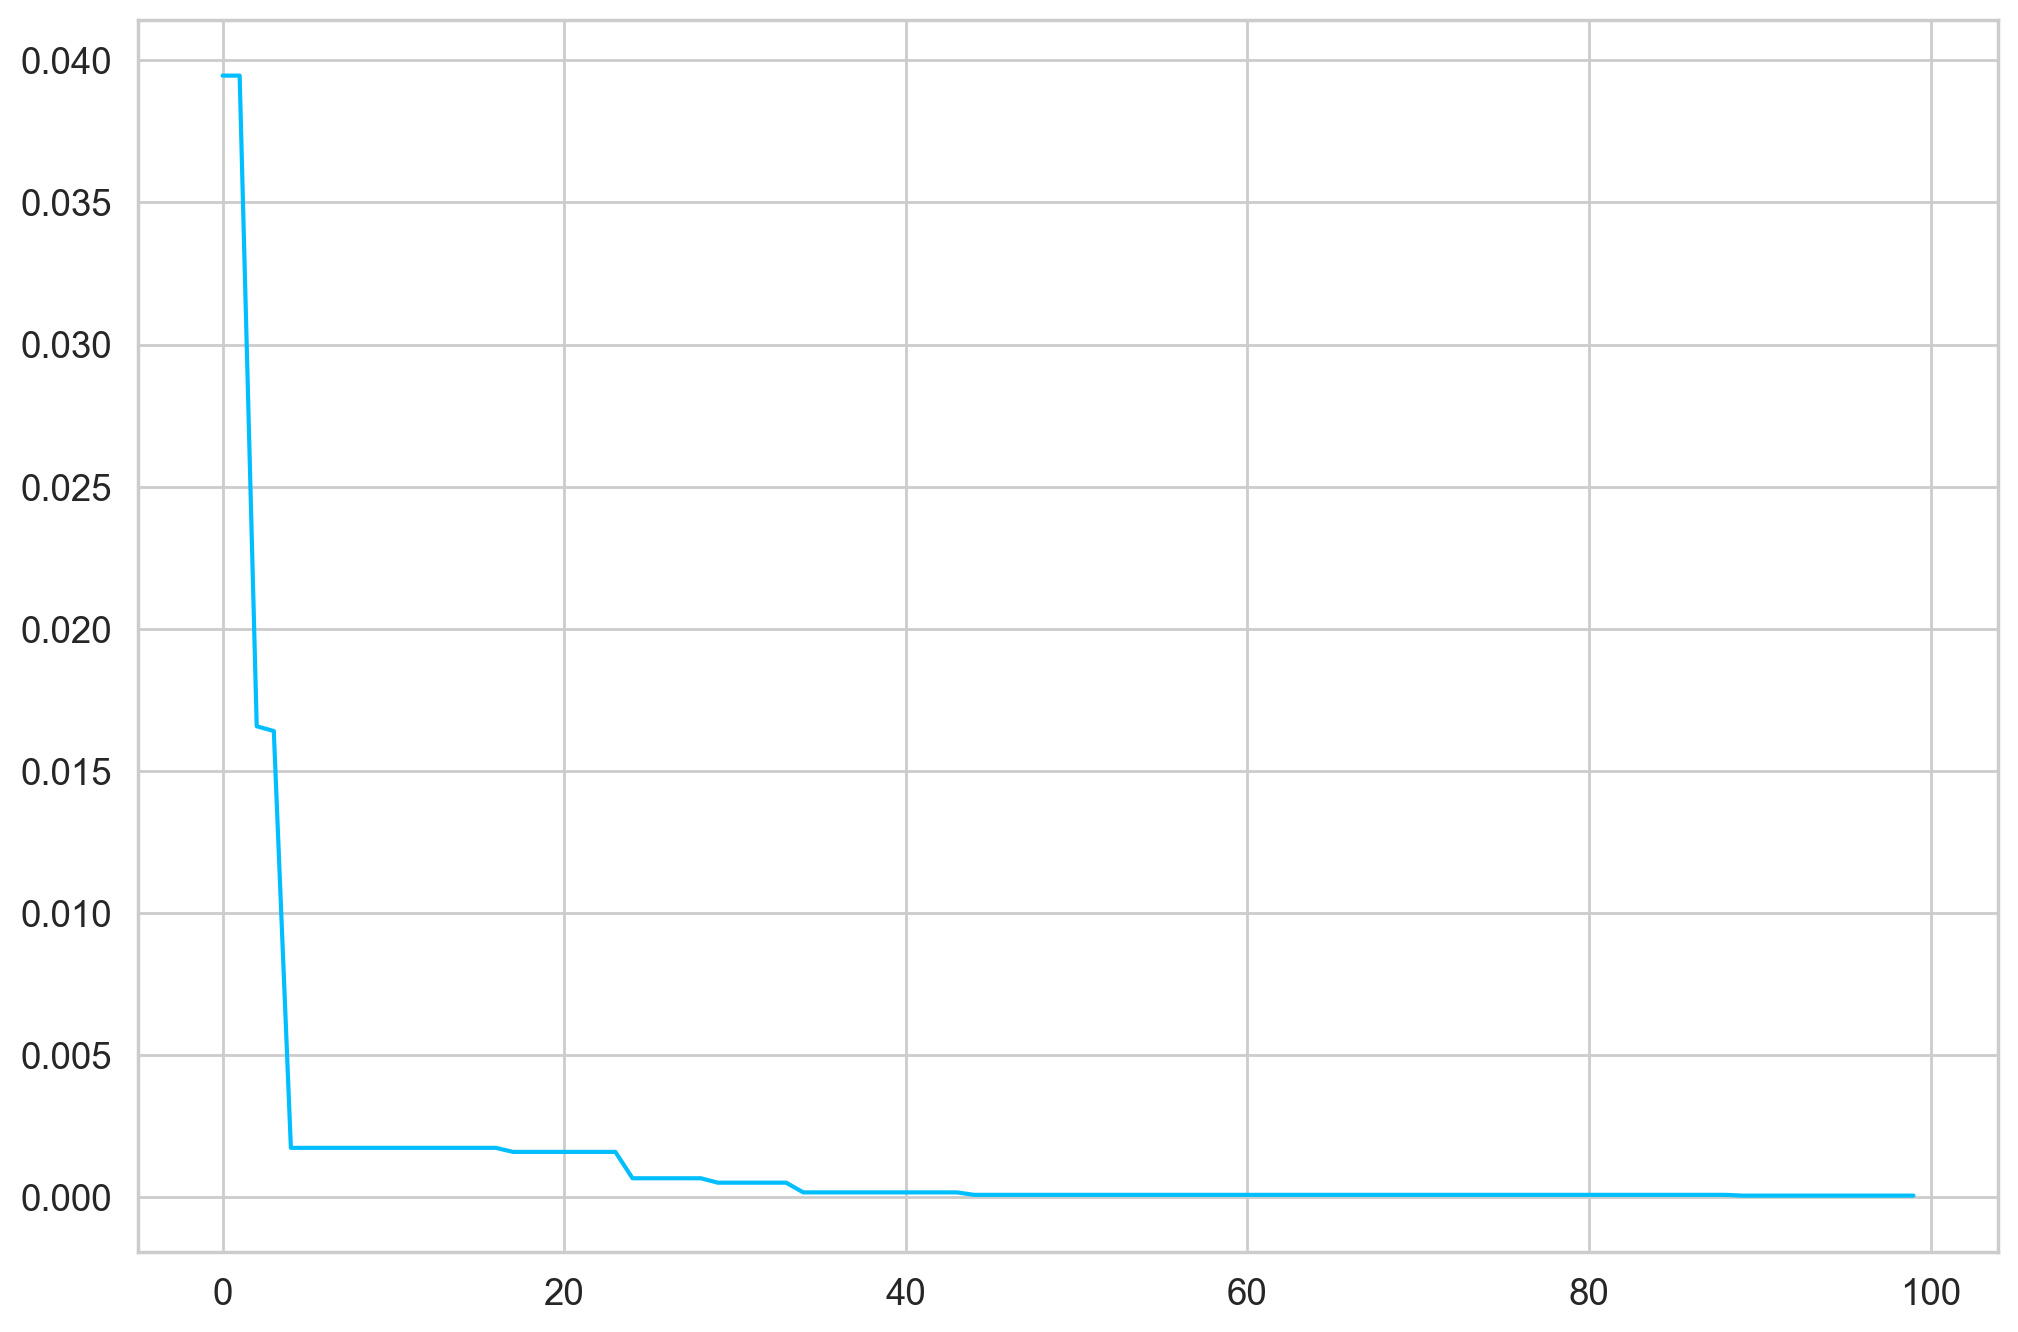

In [22]:
plt.plot(all_res_eb1[0][2])

In [87]:
file = open('svmd_ebqpso_1', 'ab')
pickle.dump(all_results_eb, file)
file.close()

In [47]:
df = pd.read_csv('inputs/DS1_1440.csv')

In [58]:
error = df.wind_speed.values - imfs.sum(axis=0)

In [59]:
error.shape

(1440,)

In [60]:
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [61]:
class WindDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        item = self.x[idx]
        label = self.y[idx]
        
        return item, label

In [62]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMForecast, self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        # self.seq_length = seq_length #sequence length
        self.num_classes = num_classes #number of classes

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 100) #fully connected 1
        self.fc = nn.Linear(100, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [63]:
from processing import create_features, split_data

In [64]:
window_size = 5
train_len = int(.6*len(error))

In [65]:
train_data, val_data, test_data = split_data(error, train_len)
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)

In [66]:
train_data.shape

(864,)

In [67]:
xtrain, ytrain = create_features(train_data, window_size)
xval, yval = create_features(val_data, window_size)
xtest, ytest = create_features(test_data, window_size)

In [68]:
train = WindDataset(xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1]), ytrain)
valid = WindDataset(xval.reshape(xval.shape[0], 1, xval.shape[1]), yval)
test = WindDataset(xtest.reshape(xtest.shape[0], 1, xtest.shape[1]), ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [69]:
input_size = 5 #number of features
hidden_size = 200 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
seq_length = 1

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMForecast(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [71]:
for p in model.parameters():
    print(p.shape)

torch.Size([800, 5])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([100, 200])
torch.Size([100])
torch.Size([1, 100])
torch.Size([1])


In [72]:
NUM_EPOCHS = 200

In [73]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [74]:
for epoch in range(NUM_EPOCHS):
    print('epochs {}/{}'.format(epoch+1, NUM_EPOCHS))
    Train()
    Valid()
    gc.collect()

epochs 1/200
train_loss 0.7663249969482422
valid_loss 0.7623250484466553
epochs 2/200
train_loss 0.7590325474739075
valid_loss 0.7551649808883667
epochs 3/200
train_loss 0.7515994310379028
valid_loss 0.747331976890564
epochs 4/200
train_loss 0.7433217763900757
valid_loss 0.7385542988777161
epochs 5/200
train_loss 0.734048068523407
valid_loss 0.7287013530731201
epochs 6/200
train_loss 0.7236801981925964
valid_loss 0.7177753448486328
epochs 7/200
train_loss 0.7122679352760315
valid_loss 0.7058544158935547
epochs 8/200
train_loss 0.6999645829200745
valid_loss 0.6931143999099731
epochs 9/200
train_loss 0.6868378520011902
valid_loss 0.6795574426651001
epochs 10/200
train_loss 0.6729698181152344
valid_loss 0.6653382182121277
epochs 11/200
train_loss 0.658523440361023
valid_loss 0.6506674289703369
epochs 12/200
train_loss 0.6437563896179199
valid_loss 0.6357881426811218
epochs 13/200
train_loss 0.6288812160491943
valid_loss 0.6209201216697693
epochs 14/200
train_loss 0.6141579151153564
valid_

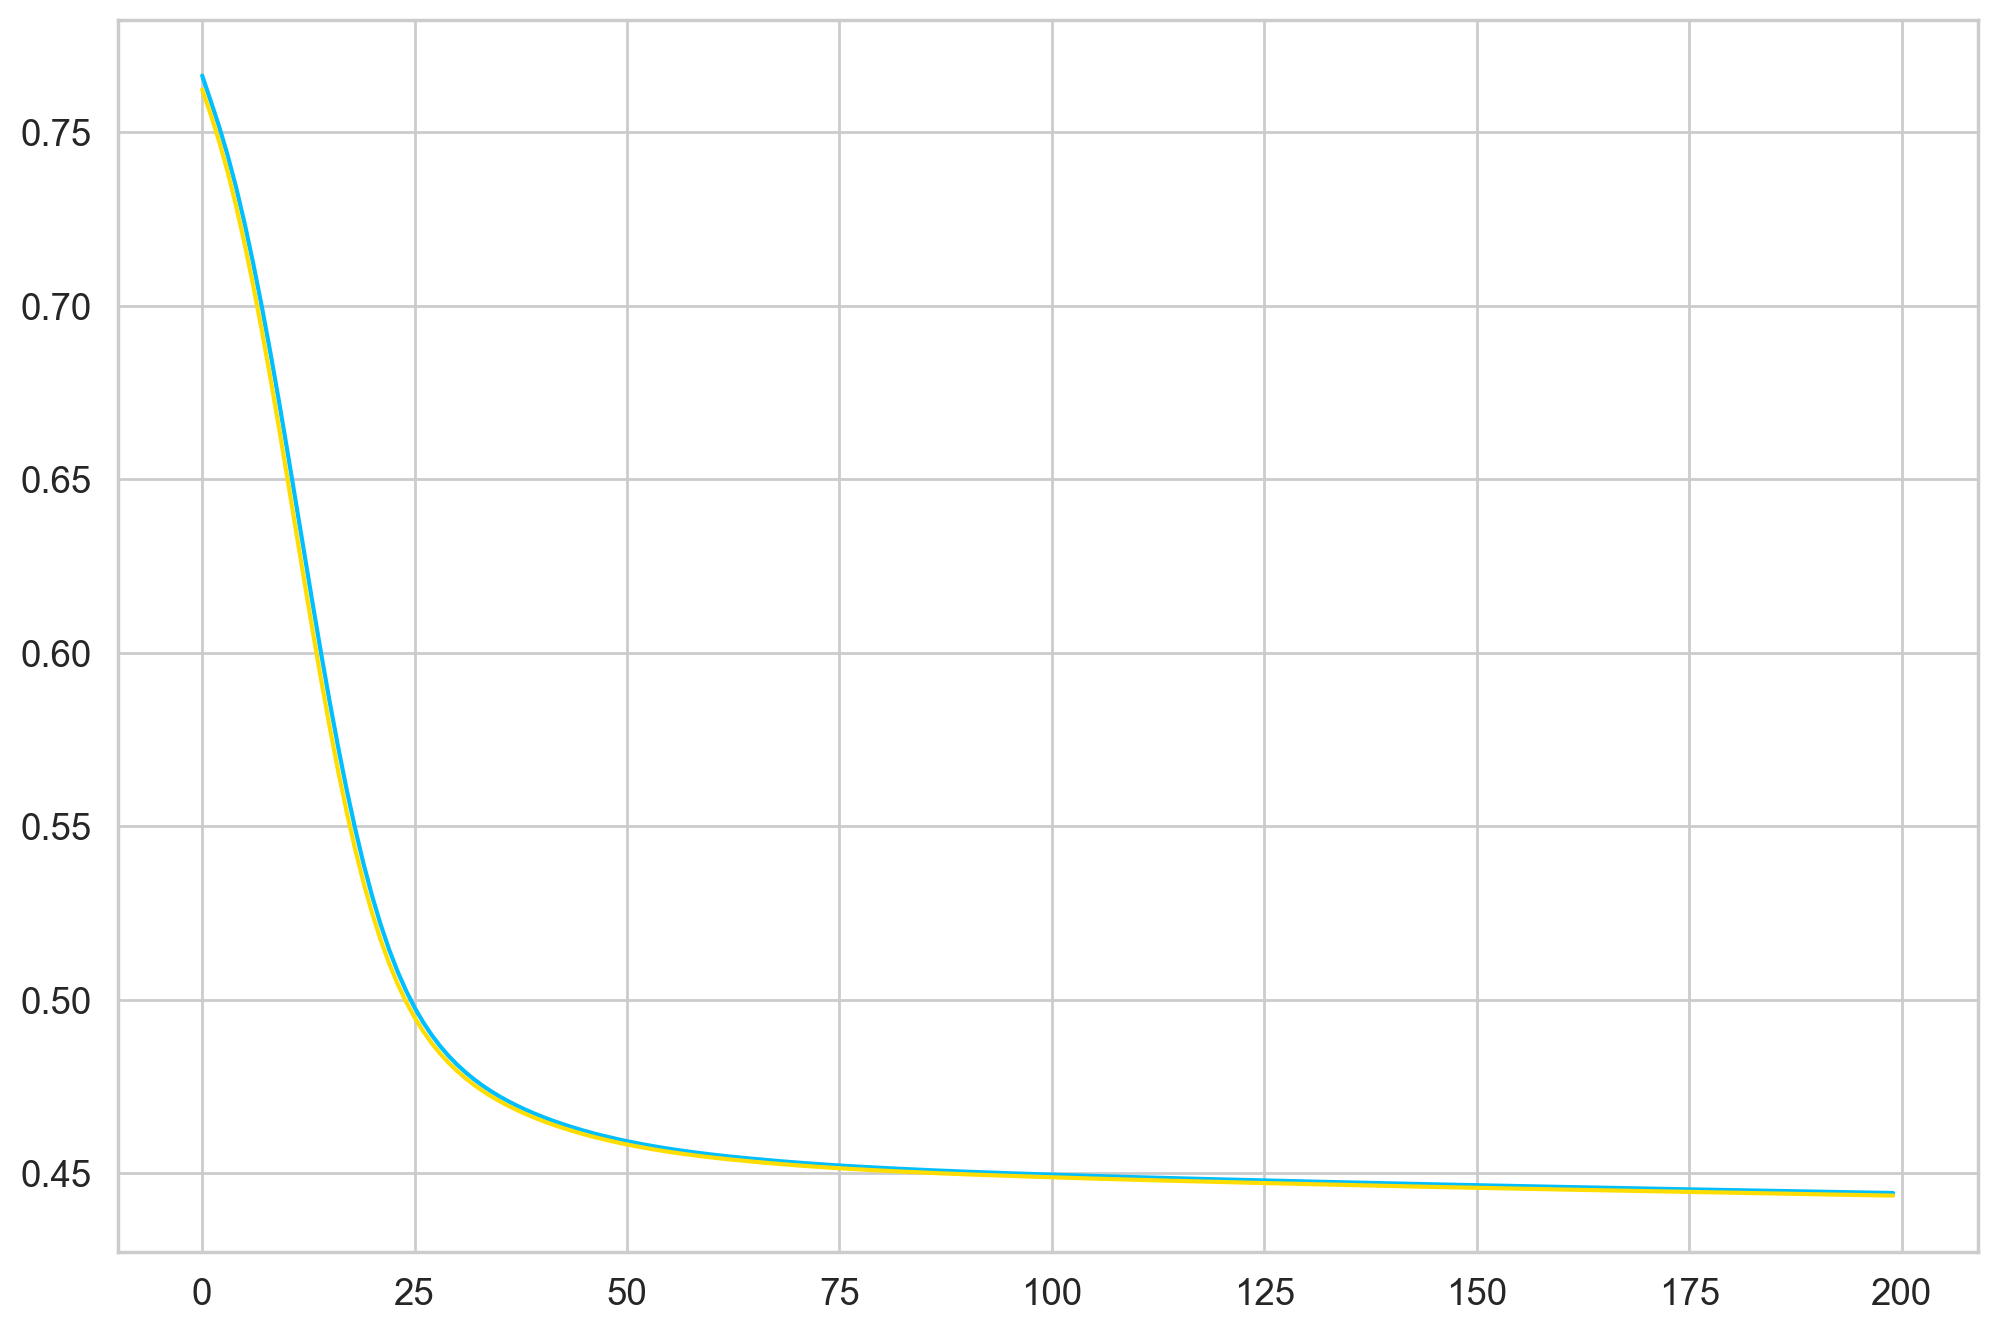

In [75]:
plt.plot(train_losses)
plt.plot(valid_losses)

In [76]:
predictions = []
test_losses = []
running_loss = 0.
model.eval()
with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model.forward(inputs)
        predictions.append(preds.item())
        loss = criterion(preds,labels)
        running_loss += loss
        
    test_loss = running_loss/len(valid_loader)
    test_losses.append(test_loss.detach().numpy())

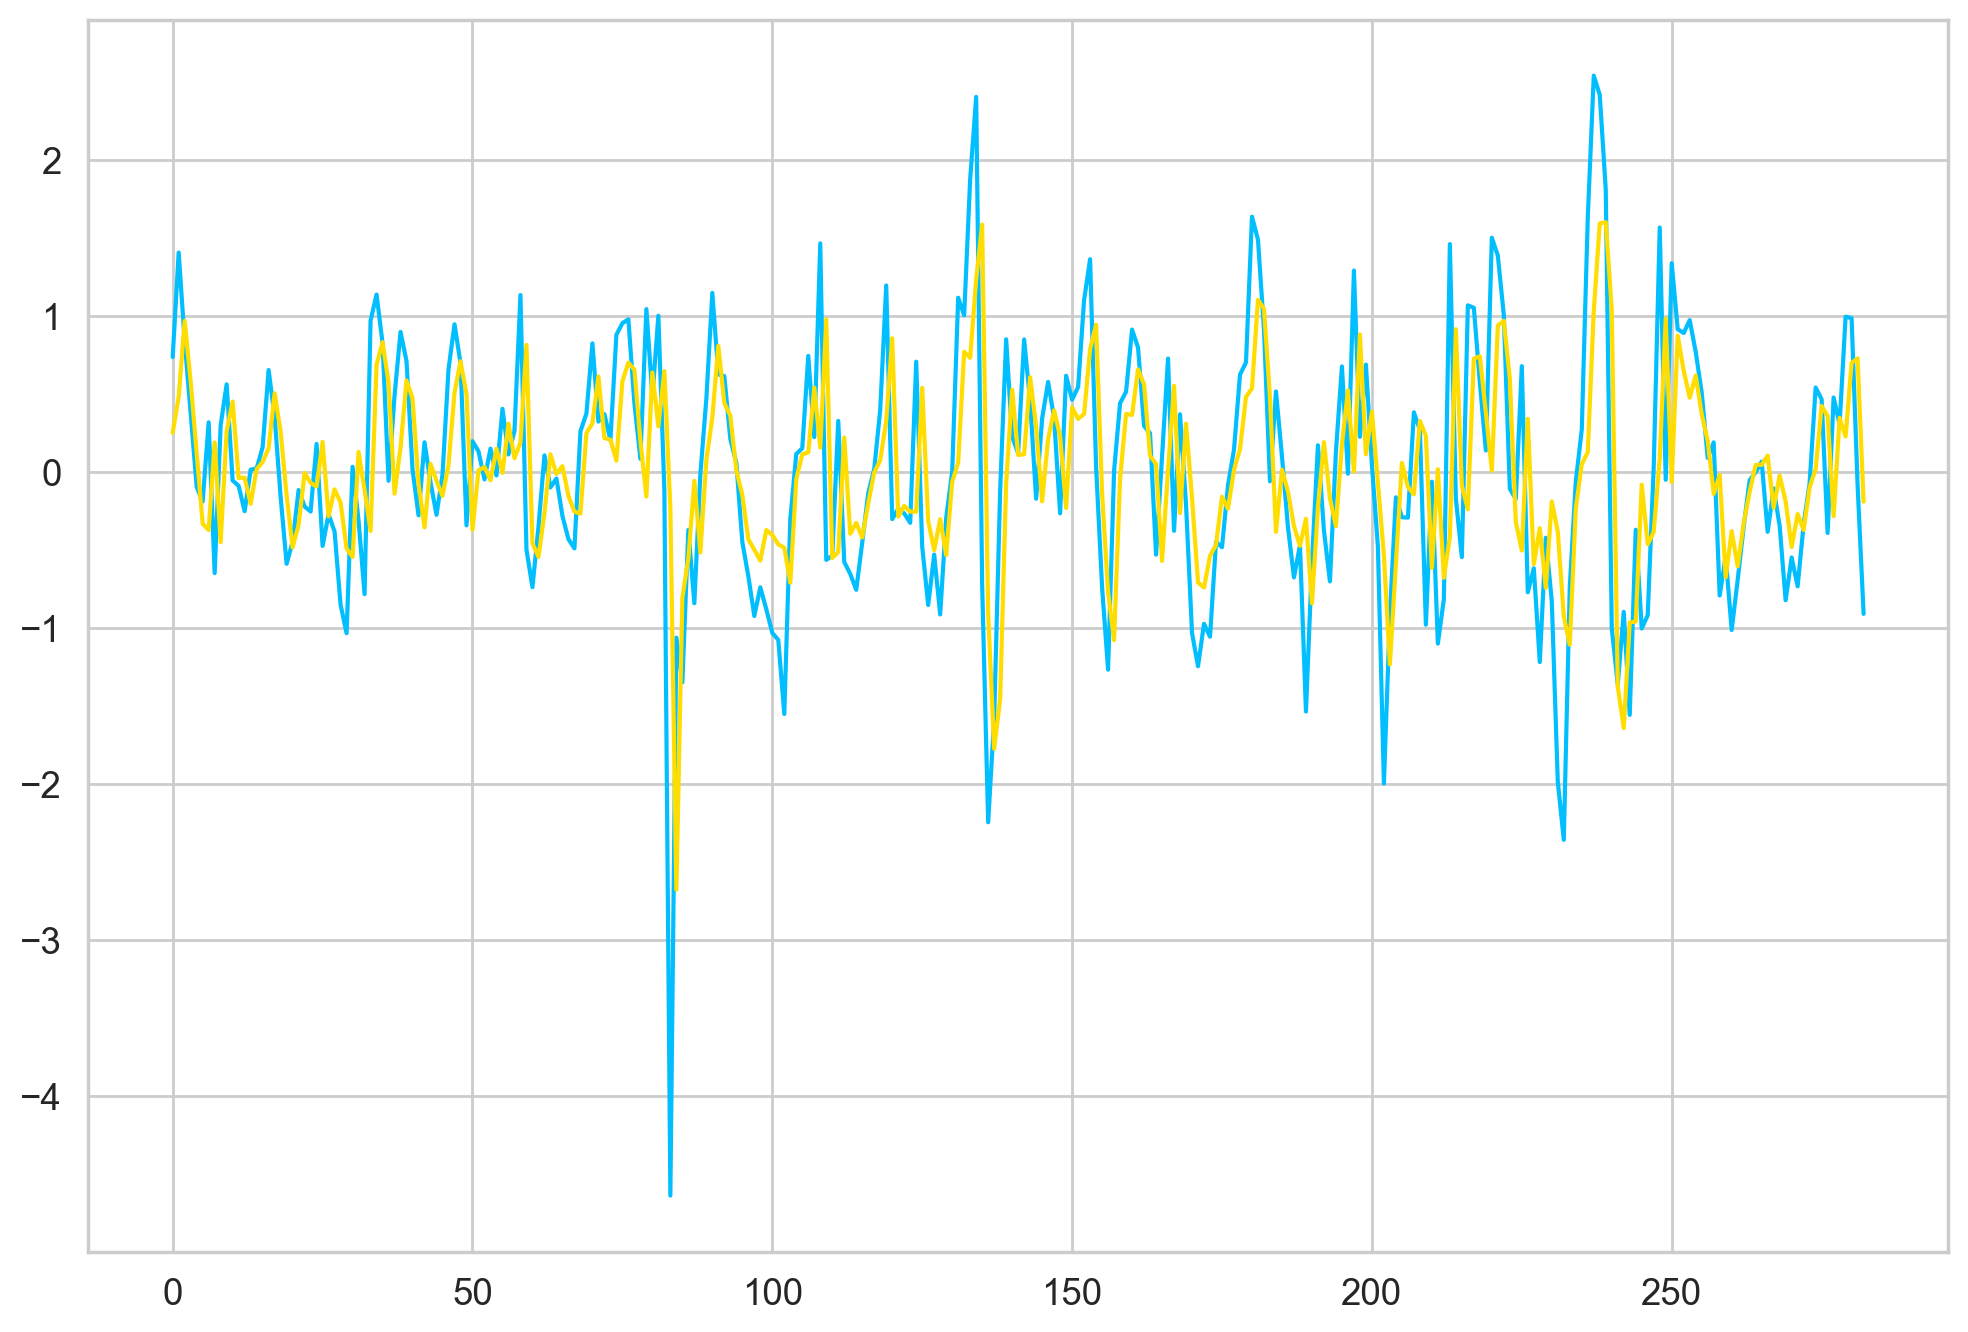

In [77]:
plt.plot(ytest)
plt.plot(predictions)

In [78]:
import pickle

In [79]:
file = open('error_svmd_eb_lssvm_1', 'ab')
pickle.dump(predictions, file)
file.close()

#### May Dataset

In [80]:
df = pd.read_csv('inputs/SVMD_2.csv')

In [81]:
df

,IMF-1,IMF-2,IMF-3,IMF-4,IMF-5,IMF-6
0,8.975682,-0.038366,0.624298,-0.111836,-1.479115,0.140007
1,8.975958,-0.039837,0.619370,-0.108724,-1.371954,0.109530
2,8.976509,-0.042764,0.609499,-0.102614,-1.165522,0.055161
3,8.977335,-0.047117,0.594654,-0.093728,-0.875014,-0.011347
4,8.978432,-0.052852,0.574799,-0.082388,-0.521791,-0.075600
...,...,...,...,...,...,...
1483,5.601922,0.361429,-1.515532,-0.451945,0.235773,0.090175
1484,5.599218,0.370347,-1.653226,-0.527500,0.425384,0.033315
1485,5.597188,0.377066,-1.759060,-0.586277,0.582773,-0.030621
1486,5.595834,0.381560,-1.830853,-0.626484,0.695309,-0.085161


In [82]:
imfs_2 = np.array([df[col] for col in df.columns])

In [83]:
imfs_2.shape

(6, 1488)

In [84]:
all_results_eb_2 = {}

In [95]:
for i in range(len(imfs_2)):
    X = imfs_2[i, :]
    params, best_err, hist = EBQPSO(f, D, nPop, lb, ub, maxit, lambda_)
    all_results_eb_2[i] = [adjust_params(params), best_err, hist]
    

In [ ]:
file = open('svmd_ebqpso_2', 'ab')
pickle.dump(all_results_eb_2, file)
file.close()

In [86]:
df = pd.read_csv('inputs/DS2_1448.csv')

In [87]:
error = df.wind_speed.values - imfs_2.sum(axis=0)

In [88]:
error.shape

(1488,)

In [89]:
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [90]:
window_size = 5
train_len = int(.6*len(error))

In [91]:
train_data, val_data, test_data = split_data(error, train_len)
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)

In [92]:
train_data.shape

(892,)

In [93]:
xtrain, ytrain = create_features(train_data, window_size)
xval, yval = create_features(val_data, window_size)
xtest, ytest = create_features(test_data, window_size)

In [94]:
train = WindDataset(xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1]), ytrain)
valid = WindDataset(xval.reshape(xval.shape[0], 1, xval.shape[1]), yval)
test = WindDataset(xtest.reshape(xtest.shape[0], 1, xtest.shape[1]), ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [95]:
input_size = 5 #number of features
hidden_size = 200 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
seq_length = 1

In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMForecast(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [97]:
for p in model.parameters():
    print(p.shape)

torch.Size([800, 5])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([100, 200])
torch.Size([100])
torch.Size([1, 100])
torch.Size([1])


In [98]:
NUM_EPOCHS = 200

In [99]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [100]:
for epoch in range(NUM_EPOCHS):
    print('epochs {}/{}'.format(epoch+1, NUM_EPOCHS))
    Train()
    Valid()
    gc.collect()

epochs 1/200
train_loss 0.7846585512161255
valid_loss 0.7835086584091187
epochs 2/200
train_loss 0.7826464176177979
valid_loss 0.7814345359802246
epochs 3/200
train_loss 0.7805691361427307
valid_loss 0.779337465763092
epochs 4/200
train_loss 0.7784765958786011
valid_loss 0.7772377729415894
epochs 5/200
train_loss 0.7763606309890747
valid_loss 0.7750502824783325
epochs 6/200
train_loss 0.7741101980209351
valid_loss 0.7727581858634949
epochs 7/200
train_loss 0.7718110084533691
valid_loss 0.7704253792762756
epochs 8/200
train_loss 0.7694495916366577
valid_loss 0.7680137157440186
epochs 9/200
train_loss 0.7669953107833862
valid_loss 0.7654873728752136
epochs 10/200
train_loss 0.7644118666648865
valid_loss 0.7628380656242371
epochs 11/200
train_loss 0.7617131471633911
valid_loss 0.7600628733634949
epochs 12/200
train_loss 0.7589042782783508
valid_loss 0.7571887969970703
epochs 13/200
train_loss 0.7559768557548523
valid_loss 0.7541905045509338
epochs 14/200
train_loss 0.7529401183128357
vali

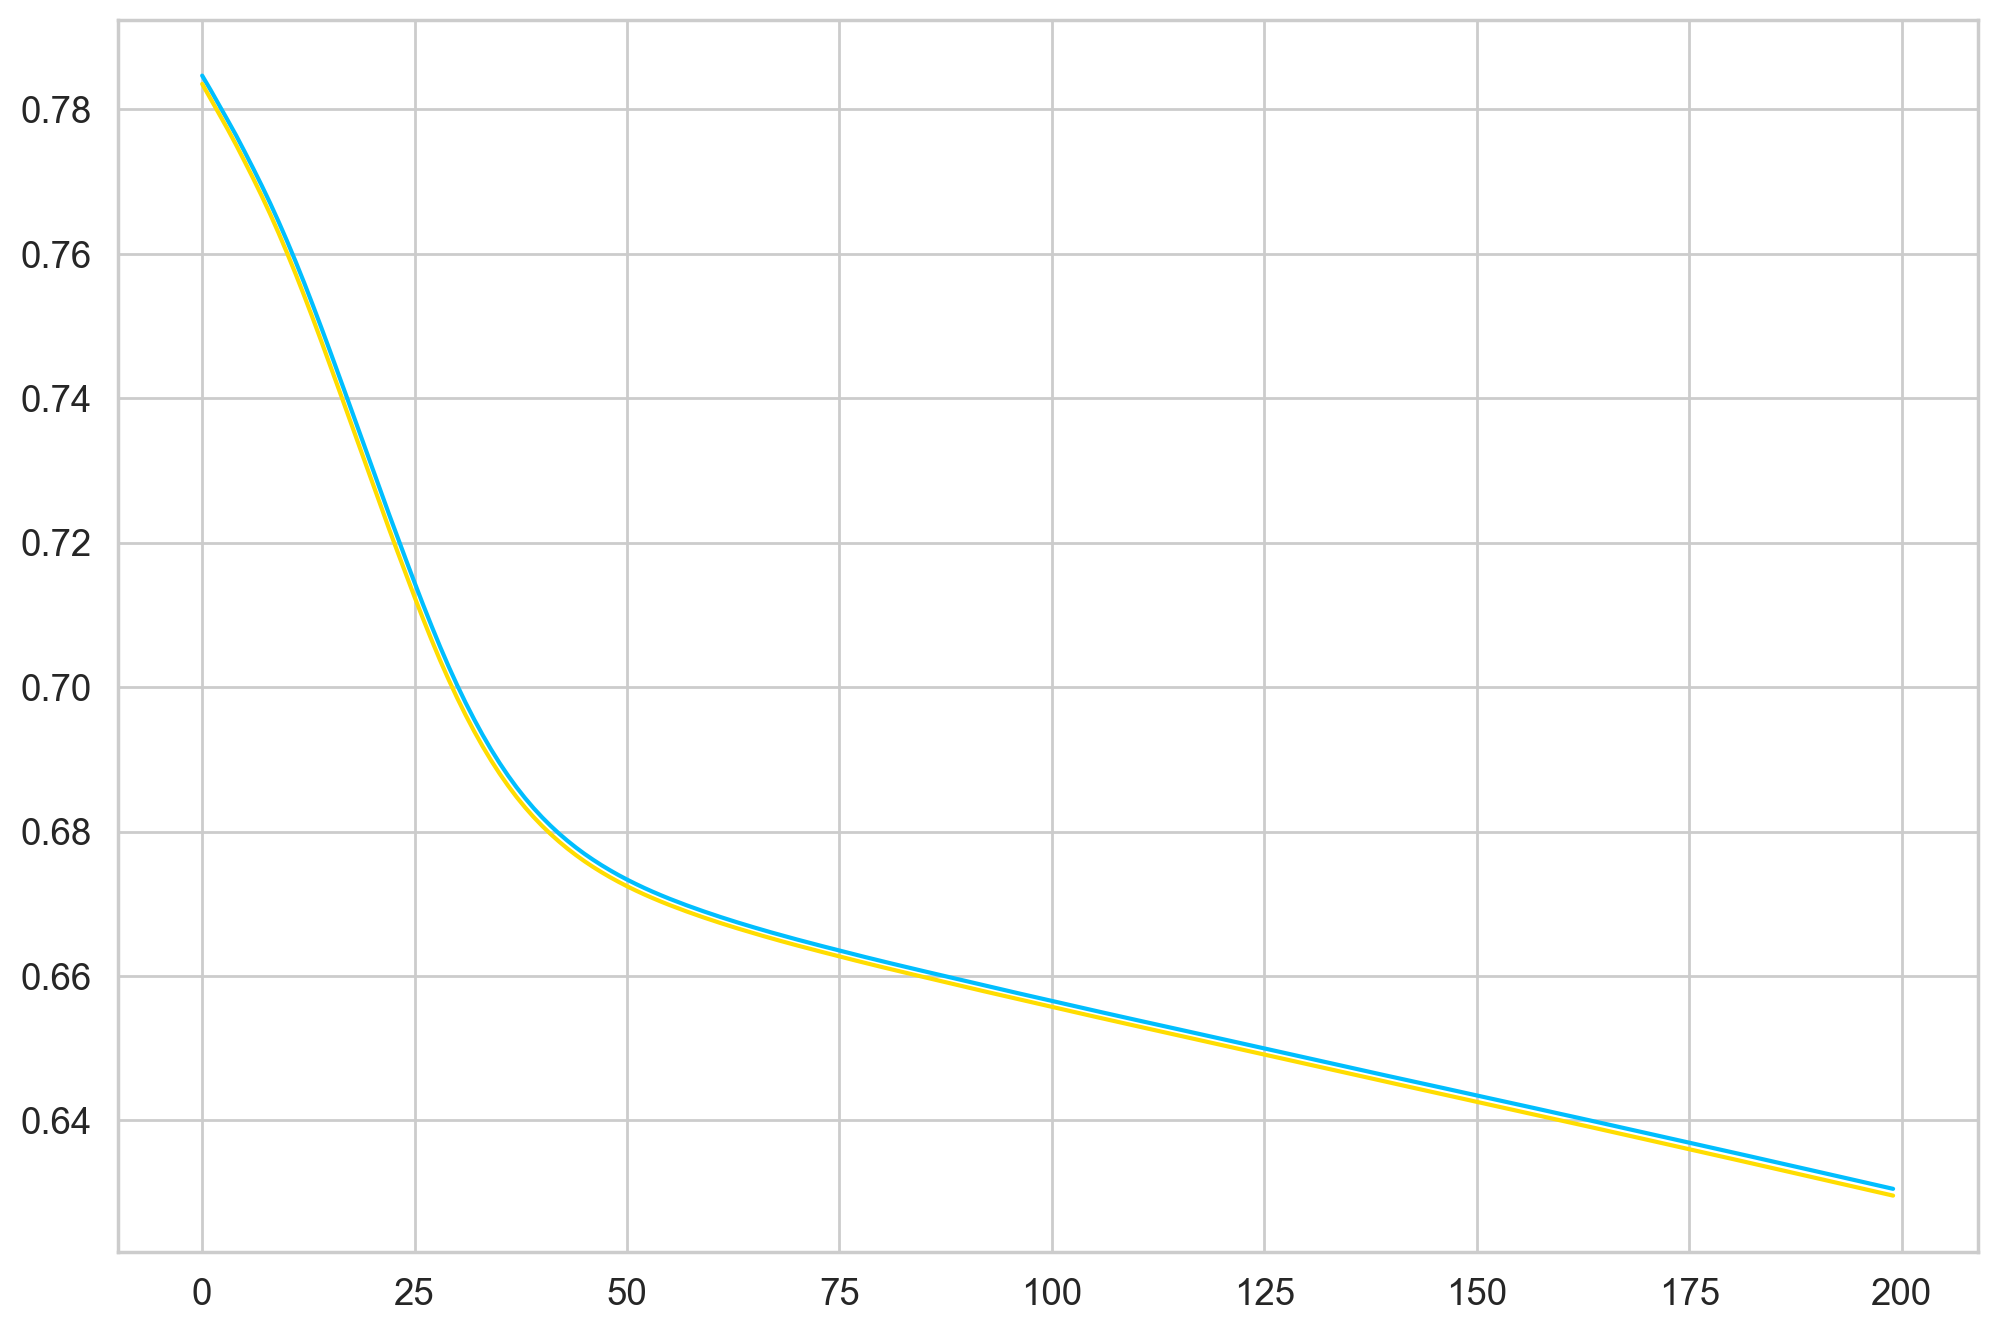

In [101]:
plt.plot(train_losses)
plt.plot(valid_losses)

In [102]:
predictions = []
test_losses = []
running_loss = 0.
model.eval()
with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model.forward(inputs)
        predictions.append(preds.item())
        loss = criterion(preds,labels)
        running_loss += loss
        
    test_loss = running_loss/len(valid_loader)
    test_losses.append(test_loss.detach().numpy())

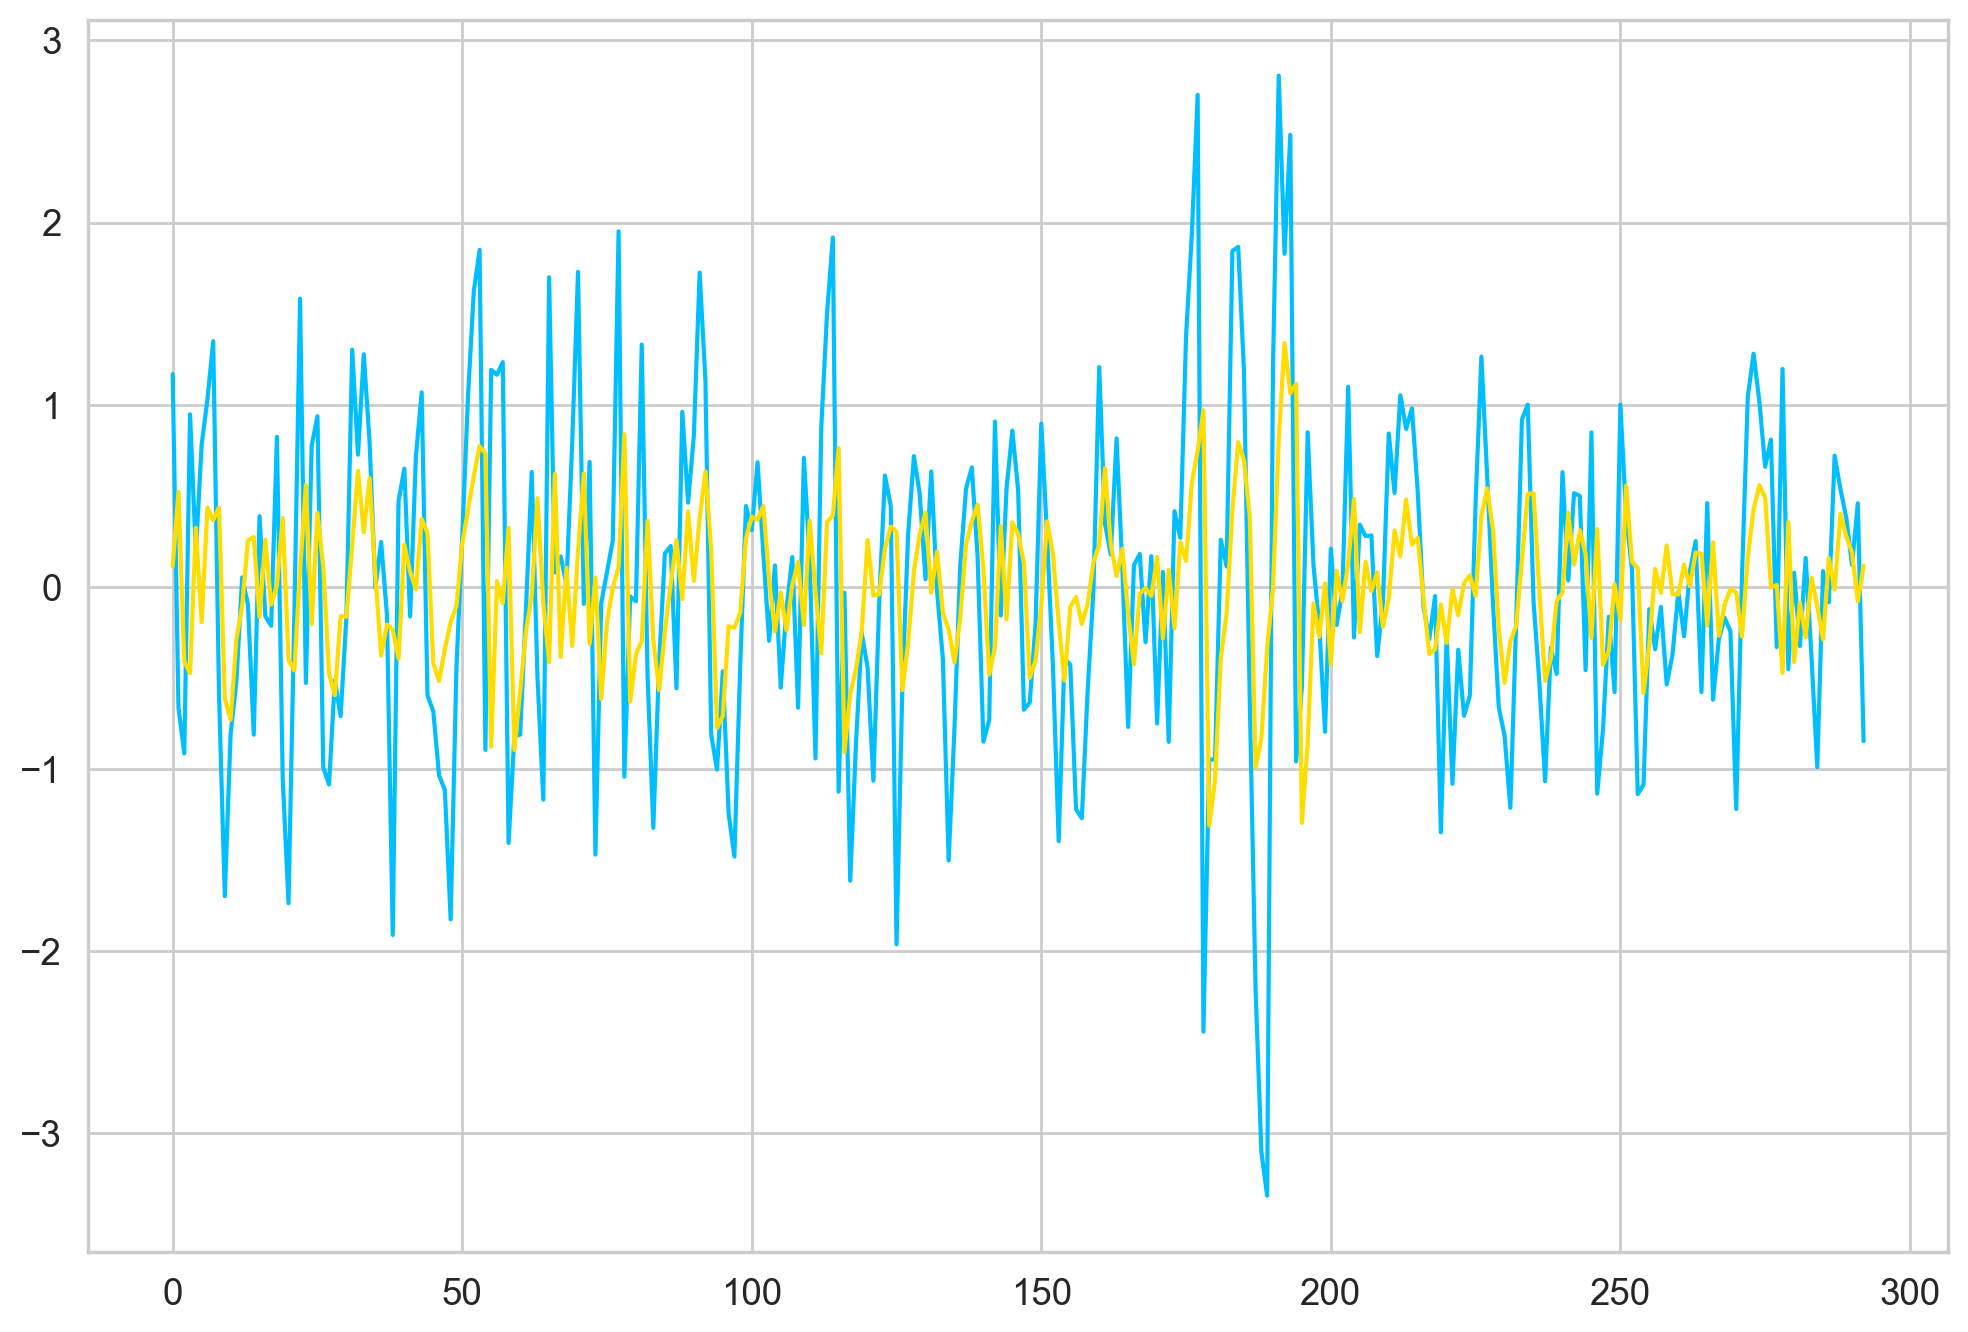

In [103]:
plt.plot(ytest)
plt.plot(predictions)

In [104]:
import pickle

In [105]:
file = open('error_svmd_eb_lssvm_2', 'ab')
pickle.dump(predictions, file)
file.close()

In [84]:
for i in range(5):
    print(all_results_eb[i][1])

6.416298508687886e-05
0.0002593228758193951
0.0008102064756411002
0.0007092862327713127
0.00034426424149213726


In [78]:
for i in range(5):
    print(all_res_p[i][1])

0.00010753946135394066
0.0003157904490286344
0.000810137744272622
0.0007092861881168852
0.00032927844947290514


In [82]:
for i in range(5):
    print(all_res_q[i][1])

8.715923809241029e-05
0.00031579875712524005
0.0008101396185781249
0.0007092881696410329
0.00035896471402841373


In [22]:
from qpso import QPSO

In [23]:
all_res_q = {}

In [24]:
for i in range(len(imfs)):
    X = imfs[i]
    params, best_err, hist = QPSO(f, D, nPop, lb, ub, maxit)
    all_res_q[i] = [adjust_params(params), best_err, hist]
    

In [27]:
all_res_q[2][:2]

[[1000.0, 2.012134847038963, 4], 0.0008106019534017482]

In [30]:
params, best_err, hist = QPSO(f, D, nPop, lb, ub, maxit)

In [29]:
all_res_p = {}

In [49]:
from pso import pso

In [52]:
for i in range(len(imfs)):
    X = imfs[i]
    params, best_err, hist = pso(f, lb, ub, swarmsize=nPop, maxiter=maxit)
    all_res_p[i] = [adjust_params(params), best_err, hist]
    

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


In [76]:
all_res_p[0][1]

0.00010753946135394066

In [86]:
file = open('vmd_pso', 'ab')
pickle.dump(all_res_p, file)
file.close()

In [25]:
file = open('vmd_qpso', 'ab')
pickle.dump(all_res_q, file)
file.close()

In [ ]:
file = open('svmd_ebqpso_1', 'ab')
pickle.dump(all_results_eb_1, file)
file.close()

In [70]:
all_res_q.keys()

dict_keys([0, 1, 2, 3, 4])

In [51]:
pso(f, lb, ub, swarmsize=nPop, maxiter=maxit)

Stopping search: Swarm best objective change less than 1e-08


(array([3.        , 0.44874739, 6.29992727]),
 0.00010739495332589927,
 [0.00024333987933123993,
  0.00024333987933123993,
  0.00014232316353515986,
  0.00012242954519293105,
  0.00010739852489134511,
  0.00010739852489134511,
  0.00010739852489134511,
  0.00010739852489134511,
  0.00010739852489134511,
  0.00010739852489134511])

In [32]:
best_err

0.00031588543392647783

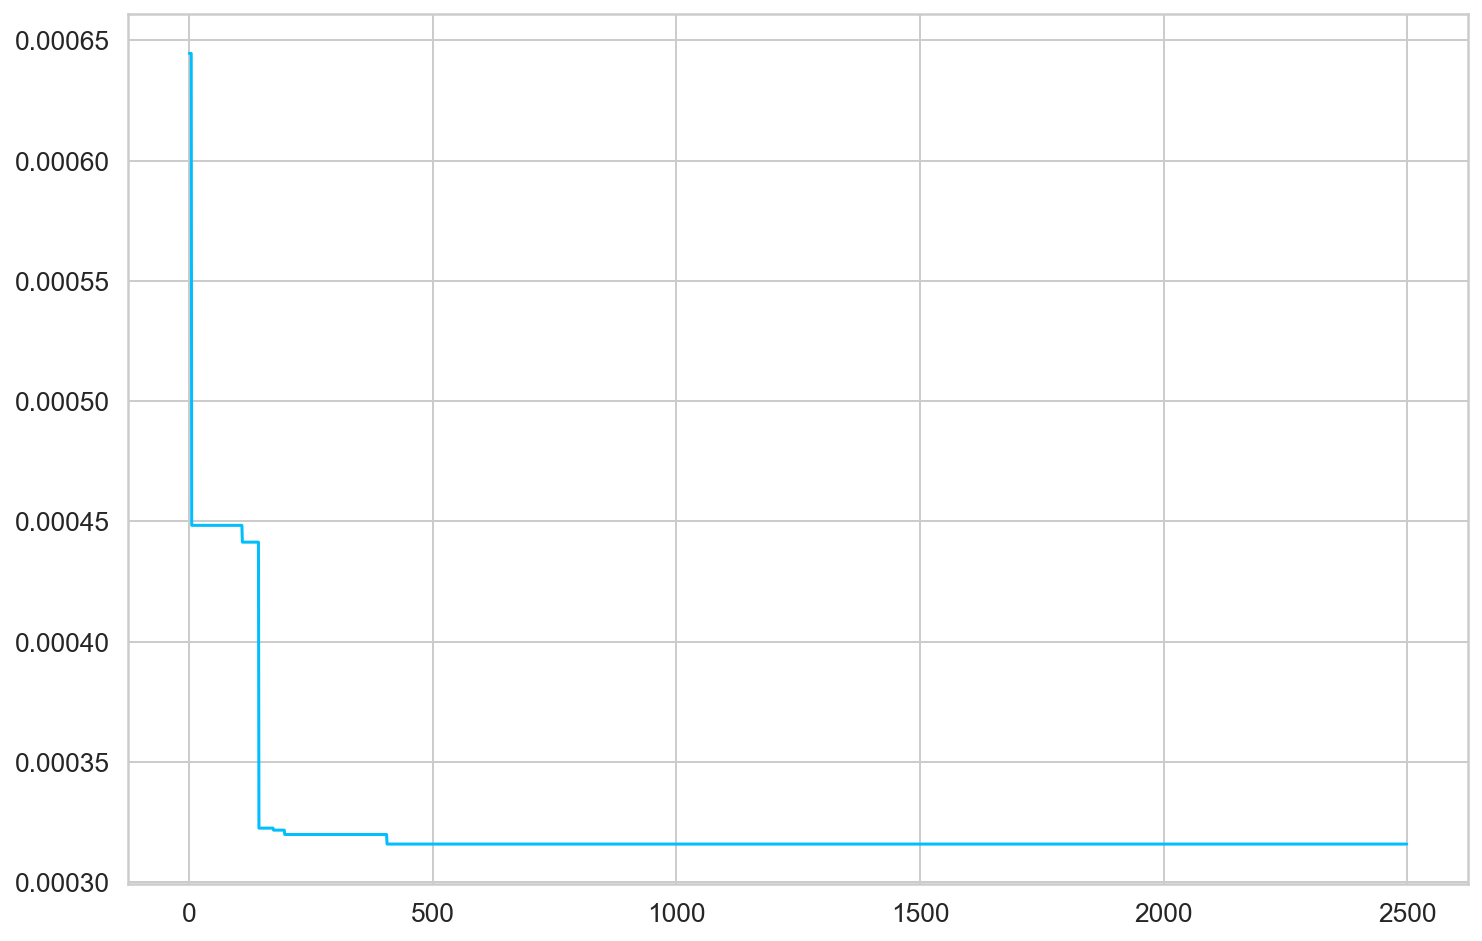

In [33]:
plt.plot(hist)

In [34]:
from pyswarm import pso

In [37]:
xopt, fopt = pso(f, lb, ub, maxiter=maxit)

Stopping search: Swarm best objective change less than 1e-08


In [38]:
xopt

array([3.        , 0.39223398, 3.64247139])

In [39]:
fopt

0.00031579063605412634

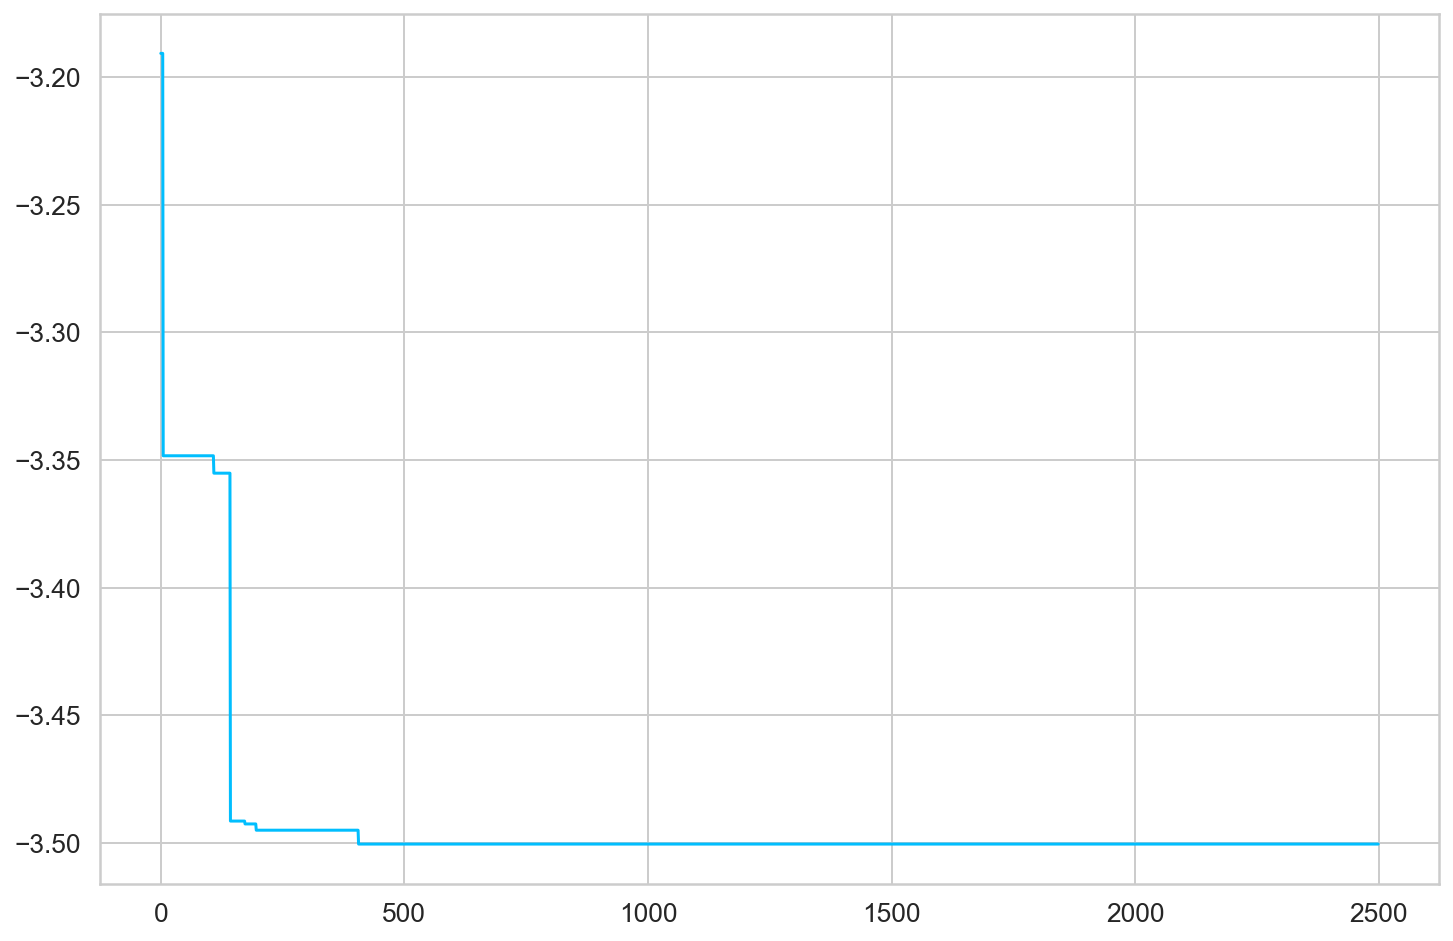

In [41]:
plt.plot(np.log10(hist))